<a href="https://colab.research.google.com/github/FrederickAlmeida/FashionMNIST-models-comparison/blob/main/ListaPraticaMLPConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LISTA PRÁTICA DAS UNIDADES 1 E 2**

Pode ser feita com o grupo do projeto. Recomendo pair/group programming para que todos vejam um pouco de todas as partes.


Treine e avalie 4 modelos de classificação para a base de dados do FashionMNIST (https://www.kaggle.com/datasets/zalando-research/fashionmnist,
https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).



1.   Um modelo base que não seja uma rede neural, como _decision tree, xgboost, random forest_, etc. Recomendação: use o sklearn (https://scikit-learn.org/).

2.   Uma MLP

3. Uma rede convolucional criada por ti. Recomendação: https://pytorch.org/

4. Use um modelo pré treinado já consolidado na literatura para fazer _transfer learning_. Recomendações: https://pytorch.org/hub/pytorch_vision_vgg/


Compare os resultados dos modelos:
* plote gráficos que mostrem as acurácias de cada modelo
* Indique qual foi a classe na qual o modelo teve pior performance (indique qual métrica usou para concluir isso e faça para cada modelo)
* argumente qual o melhor modelo levando em consideração o tempo de execução e acurácia.

Recomendação use:
https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html .



Recomendação:

Faça um template de treino, validação e teste que funcione para uma API de modelo.

Crie a API para cada modelo que será usado e use o template

# Imports e Downloads

In [27]:
# modelagem e dados
from sklearn.ensemble import RandomForestClassifier

import torch
from torchvision import datasets, transforms
from torch.utils import data
import joblib

# avaliação
from torchsummary import summary
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor()
])

In [5]:
train_ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=augmentation_transforms
)

test_ds = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=augmentation_transforms
)

In [6]:
length = len(train_ds)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])

In [7]:
len_train, len_val, len(test_ds)

(51000, 9000, 10000)

In [8]:
BATCH_SIZE = 128
NUM_WORKERS = 2

train_dl = data.DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

In [9]:
instances, targets = next(iter(train_dl))
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

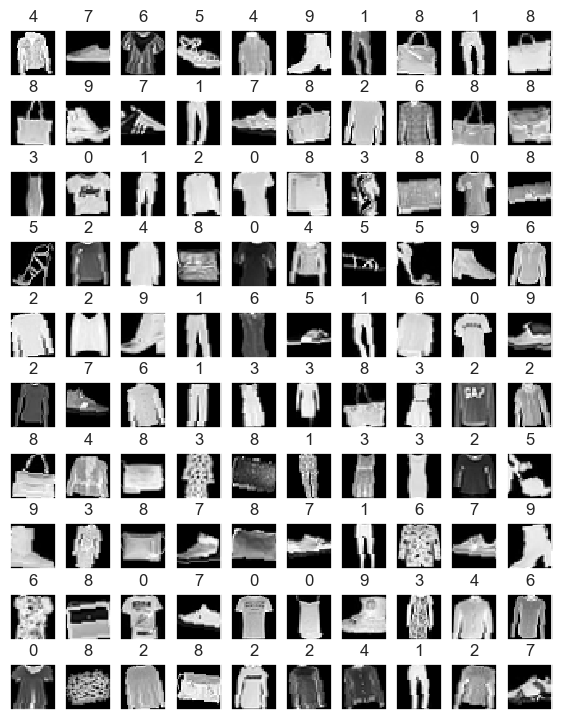

In [10]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
    for j in range(w):
        ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        label = targets[i * w + j].item()
        ax[i][j].set_title(label)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

# Modelo base

In [14]:
# processar os dados para que se tornem tensores de 1 dimensão, a fim de utilizar random forest
def preprocess(dataset):
    LENGTH = len(dataset)
    loader = torch.utils.data.DataLoader(dataset, batch_size=LENGTH, shuffle=False)

    for data, labels in loader:
        data = data.numpy().reshape(LENGTH, -1)
        labels = labels.numpy()
        break

    data_transformed = data / 255.0

    return data_transformed, labels

In [15]:
X_train, y_train = preprocess(train_ds)
X_val, y_val = preprocess(val_ds)
X_test, y_test = preprocess(test_ds)

In [17]:
X_train.shape, y_train.shape

((51000, 784), (51000,))

In [19]:
type(X_train)

numpy.ndarray

In [28]:
def train_forest(X_train, y_train, X_val, y_val):
    best_model = 0

    for estimators in range(100, 1001, 100):
        classifier = RandomForestClassifier(n_estimators=estimators, random_state=1)

        classifier.fit(X_train, y_train)

        predictions = classifier.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        print(f"estimators = {estimators}, accuracy = {accuracy:.4f}")

        if (accuracy > best_model):
            joblib.dump(classifier, 'random_forest_model.joblib')
            best_model = accuracy

In [29]:
train_forest(X_train, y_train, X_val, y_val)

estimators = 100, accuracy = 0.8101
estimators = 200, accuracy = 0.8127
estimators = 300, accuracy = 0.8129
estimators = 400, accuracy = 0.8140
estimators = 500, accuracy = 0.8143
estimators = 600, accuracy = 0.8150
estimators = 700, accuracy = 0.8149
estimators = 800, accuracy = 0.8158
estimators = 900, accuracy = 0.8147
estimators = 1000, accuracy = 0.8149


In [ ]:
# loading the best model
rf_classifier = joblib.load('random_forest_model.joblib')

In [31]:
predictions = rf_classifier.predict(X_test)

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7650    0.7910    0.7778      1000
           1     0.9863    0.9380    0.9616      1000
           2     0.6409    0.7140    0.6755      1000
           3     0.7914    0.8650    0.8266      1000
           4     0.6765    0.7090    0.6924      1000
           5     0.9422    0.8960    0.9185      1000
           6     0.5626    0.4180    0.4796      1000
           7     0.8763    0.9000    0.8880      1000
           8     0.9310    0.9450    0.9380      1000
           9     0.9102    0.9320    0.9209      1000

    accuracy                         0.8108     10000
   macro avg     0.8082    0.8108    0.8079     10000
weighted avg     0.8082    0.8108    0.8079     10000



# MLP

# Rede Convolucional

# Rede Convolucional consolidada

# Comparação